# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Изучение общей информации 

Импортируем библиотеку pandas и загрузим данные из файла в датафрейм.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
data=pd.read_csv('/datasets/real_estate_data.csv', sep ='\t')

Посмотрим общую информацию по датафрейму

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В ходе изучения информации были выявленны следующие проблемы в предоставленных данных:
* `first_day_exposition` - тип object вместо datetime
* `ceiling_height` - высота потолков (м) - не все строки (14504)
* `floors_total` - всего этажей в доме - не все строки (23613); используется тип float64 вместо int64
* `living_area` - жилая площадь в квадратных метрах (м²) - не все строки (21796)
* `is_apartment` - апартаменты (булев тип) - не все строки (2775); тип object, а  должен быть bool
* `kitchen_area` - площадь кухни в квадратных метрах (м²) - не все строки (21421)
* `balcony` - число балконов - не все строки (12180); используется тип float64 вместо int64
* `locality_name` - название населённого пункта - не все строки (23650)
* `airports_nearest` - расстояние до ближайшего аэропорта в метрах (м) - не все строки (18157)
* `cityCenters_nearest` - расстояние до центра города (м) - не все строки (18180)
* `parks_around3000` - число парков в радиусе 3 км - не все строки (18181); используется тип float64 вместо int64
* `parks_nearest` - расстояние до ближайшего парка (м) - не все строки (8079)
* `ponds_around3000` - число водоёмов в радиусе 3 км - не все строки (18181); используется тип float64 вместо int64
* `ponds_nearest` — расстояние до ближайшего водоёма (м) - не все строки (9110)
* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия) - не все строки (20518); используется тип float64 вместо int64

Выведем первые 10 строк таблицы.

In [3]:
data.head(10)
pd.set_option('display.max_columns', None)

Построем общую гистограмму для всех столбцов таблицы.

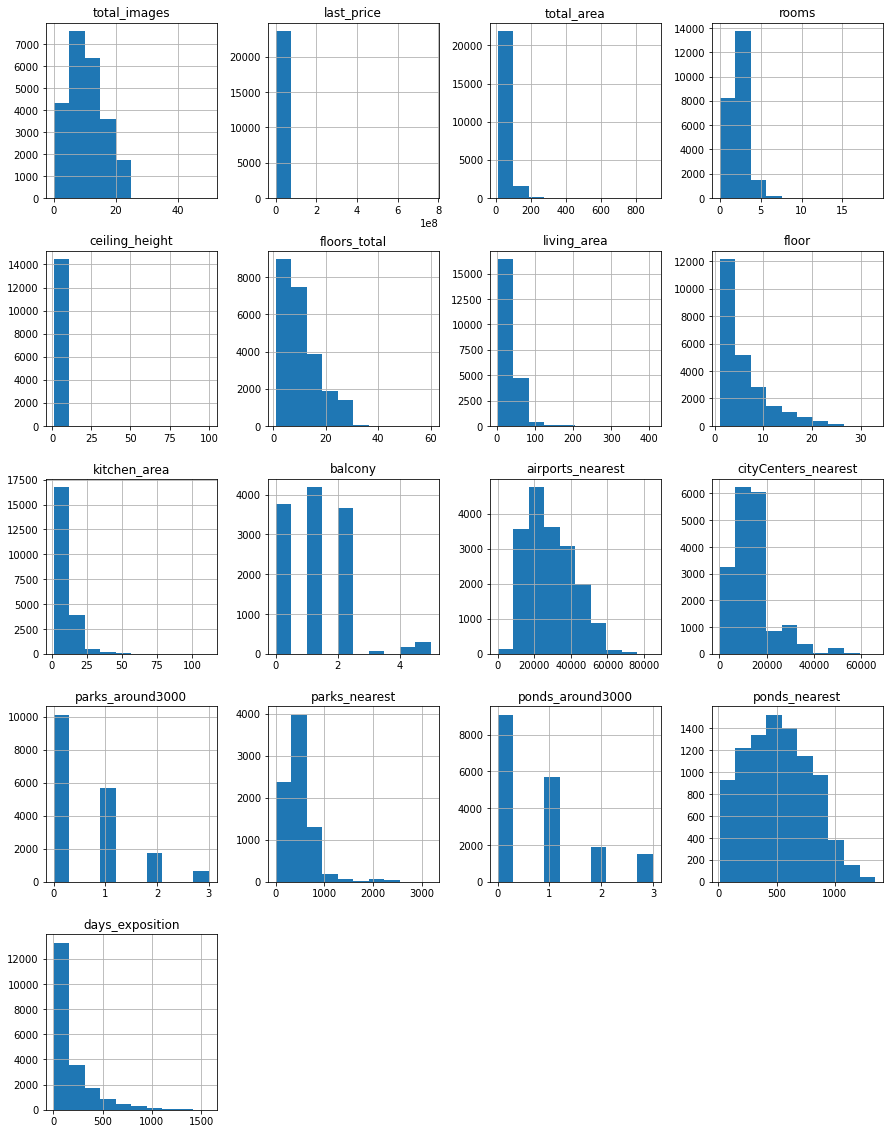

In [4]:
data.hist(figsize=(15, 20))
plt.show()

### Предобработка данных

#### Избавление от пропусков

Список столбоцов с пропущенными данными:
* `ceiling_height` - высота потолков (м) - не все строки (14504)
* `floors_total` - всего этажей в доме - не все строки (23613)
* `living_area` - жилая площадь в квадратных метрах (м²) - не все строки (21796)
* `is_apartment` - апартаменты (булев тип) - не все строки (2775)
* `kitchen_area` - площадь кухни в квадратных метрах (м²) - не все строки (21421)
* `balcony` - число балконов - не все строки (12180)
* `locality_name` - название населённого пункта - не все строки (23650)
* `airports_nearest` - расстояние до ближайшего аэропорта в метрах (м) - не все строки (18157)
* `cityCenters_nearest` - расстояние до центра города (м) - не все строки (18180)
* `parks_around3000` - число парков в радиусе 3 км - не все строки (18181)
* `parks_nearest` - расстояние до ближайшего парка (м) - не все строки (8079)
* `ponds_around3000` - число водоёмов в радиусе 3 км - не все строки (18181)
* `ponds_nearest` — расстояние до ближайшего водоёма (м) - не все строки (9110)
* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия) - не все строки (20518)

##### Высота потолков

Заполним пропущенные данные медианными значениями в зависимости от населенного пункта.

In [5]:
for locality_name in data['locality_name'].unique():
    data.loc[(data['locality_name'] == locality_name) & (data['ceiling_height'].isna()), 'ceiling_height'] =\
    data.loc[(data['locality_name'] == locality_name), 'ceiling_height'].median()
warnings.simplefilter('ignore')

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/p

Как видим, заменились не все данные. Такое могло возникнуть из-за того, что при расчете медианы было всего одно значение и то, пустое. Поэтому для оставшихся пустых ячеек данные заполним медианной по столбцу.

In [6]:
data['ceiling_height'] = data['ceiling_height']. fillna(data['ceiling_height'].median())

##### Всего этажей в доме

Для пропущенных данных будем считать, что количество этажей в доме равно этажу указанному в значении `floor`

In [7]:
data['floors_total'] = data['floors_total']. fillna(data['floor'])

##### Жилая площадь в квадратных метрах (м²)

Заполним пропущенные данные медианными значениями в зависимости от количества комнат.

In [8]:
for rooms in data['rooms'].unique():
    data.loc[(data['rooms'] == rooms) & (data['living_area'].isna()), 'living_area'] =\
    data.loc[(data['rooms'] == rooms), 'living_area'].median()

##### Апартаменты (булев тип)

Предположим, что пропущенные данные — это не аппартаменты. Тогда заполним пропущенные значения параметром False.

In [9]:
data['is_apartment'] = data['is_apartment'].fillna(False) 

##### Площадь кухни в квадратных метрах (м²)

Заполним пропущенные данные медианными значениями в зависимости от населенного пункта.

In [10]:
for locality_name in data['locality_name'].unique():
    data.loc[(data['locality_name'] == locality_name) & (data['kitchen_area'].isna()), 'kitchen_area'] =\
    data.loc[(data['locality_name'] == locality_name), 'kitchen_area'].median()
warnings.simplefilter('ignore')

Как видим, заменились не все данные. Такое могло возникнуть из-за того, что при расчете медианы было всего одно значение и то, пустое. Поэтому для оставшихся пустых ячеек данные заполним медианной по столбцу.

In [11]:
data['kitchen_area'] = data['kitchen_area']. fillna(data['kitchen_area'].median())

##### Число балконов

Предположим, что пропуски — это недвижимость без балкона. Тогда заполним все проупски нулями.

In [12]:
data['balcony'] = data['balcony'].fillna(0)

##### Название населённого пункта

Заполнить эти данные мы не можем и пропущенных строчек не так много. Удалим строчки с пропусками в столбце `locality_name` из датафрейма и пересохраним его.

In [13]:
data = data.dropna(subset=['locality_name'])

##### Расстояние до ближайшего аэропорта в метрах (м)

Эти данные мы заполнить не можем. Оставим как есть.

##### Расстояние до центра города (м)

Эти данные мы заполнить не можем. Оставим как есть.

##### Число парков в радиусе 3 км

Обратим внимание, что коливество пропусков в данном столбце совпадает с пропусками в столбце с числом водоемов в радиусе 3 км.

Предположим, что пропуски стоят там, где парки в радиусе 3 км отсуствуют. Заменим пропущенные значения на нули.

In [14]:
data['parks_around3000'] = data['parks_around3000'].fillna(0) 

##### Расстояние до ближайшего парка (м)

Эти данные мы заполнить не можем. Оставим как есть.

##### Число водоёмов в радиусе 3 км

Предположим, что пропуски стоят там, где водоемы в радиусе 3 км отсуствуют. Заменим пропущенные значения на нули.

In [15]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0) 

##### Расстояние до ближайшего водоема (м)

Эти данные мы заполнить не можем. Оставим как есть.

##### Сколько дней было размещено объявление (от публикации до снятия) 

Если тут пропуск, вероятно, квартира не продана. Пропуск заполнять не нужно.

##### Проверка

Посмотрим еще раз информацию по датафрейму.

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Как видим, данные, которыебыло можно и нужно, мы заменили.

#### Преобразование данных в столбцах

Список столбцов с неверными типами данных:
* `first_day_exposition` - тип object вместо datetime
* `floors_total` - используется тип float64 вместо int64
* `is_apartment` - тип object, а  должен быть bool
* `balcony` - используется тип float64 вместо int64
* `parks_around3000` - используется тип float64 вместо int64
* `ponds_around3000` - используется тип float64 вместо int64
* `days_exposition` - используется тип float64 вместо int64 (мы его не поменяем, т.к. в столбце остались пропуски)

Необходимо произвести замену типов данных для данных столбцов. Например, тип данных bool может понядобится потом для решения каких-то логических задач, сейчас же тип object. Или столбцы с данными, которые могут принимать только целые значения, для них праивльным будет использовать тип int. Также дата должна быть в формате datetime, иначе с ней нельзя будет производить никаких матетматических операций.

##### Из float64 в int64

Для преобразования используем метод astype().

In [17]:
data[['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']] = data[['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']].astype('int64')

##### Из object в bool

Для преобразования используем метод astype().

In [18]:
data['is_apartment'] = data['is_apartment'].astype('bool')

##### Из object в datetime

Воспользуемся методом `to_datetime`.

In [19]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

##### Проверка

Посмотрим еще раз информацию по датафрейму.

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

Как видим, теперь всем столбцам соотвествуют правильные типы данных.

#### Устранение дубликатов

Изучим столбец с названиями населенных пунктов.

In [21]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Видим, что есть неявные дубли. Посмотрим, сколько уникальных знаений на данный момент.

In [22]:
len(data['locality_name'].value_counts())

364

Избавимся от дублей в названиях типов населенных пунктов.

In [23]:
data['locality_name'] = data['locality_name'].replace('посёлок', 'поселок', regex=True)
data['locality_name'] = data['locality_name'].replace('поселок станции', 'поселок при железнодорожной станции', regex=True)
data['locality_name'] = data['locality_name'].replace('коттеджный поселок', 'поселок', regex=True)
data['locality_name'] = data['locality_name'].replace('городской поселок', 'поселок городского типа', regex=True)

Посмотрим, скоратилось ли число уникальных значений.

In [24]:
len(data['locality_name'].value_counts())

320

Посмотрим как изменился список уникальных значений.

In [25]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары',
       'поселок городского типа Янино-1', 'поселок Парголово',
       'поселок Мурино', 'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин',
       'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посел

Видим, что остались неявные дубли, когда один и тот же населнный пункт указан под разными типами. Избавимся от таких дублей.

In [26]:
data['locality_name'] = data['locality_name'].replace('деревня Зимитицы', 'поселок Зимитицы', regex=True)
data['locality_name'] = data['locality_name'].replace('поселок Гарболово', 'деревня Гарболово', regex=True)
data['locality_name'] = data['locality_name'].replace('деревня Калитино', 'поселок Калитино', regex=True)
data['locality_name'] = data['locality_name'].replace('деревня Кудрово', 'Кудрово', regex=True)
data['locality_name'] = data['locality_name'].replace('поселок Мурино', 'Мурино', regex=True)
data['locality_name'] = data['locality_name'].replace('село Никольское', 'Никольское', regex=True)
data['locality_name'] = data['locality_name'].replace('село Павлово', 'поселок городского типа Павлово', regex=True)
data['locality_name'] = data['locality_name'].replace('садовое товарищество Приладожский', 'поселок городского типа Приладожский', regex=True)
data['locality_name'] = data['locality_name'].replace('поселок Рабитицы', 'деревня Рабитицы', regex=True)
data['locality_name'] = data['locality_name'].replace('деревня Фёдоровское', 'поселок городского типа Фёдоровское', regex=True)
data['locality_name'] = data['locality_name'].replace('деревня Щеглово', 'поселок Щеглово', regex=True)

Посмотрим,к ак теперь изменилось число уникальных значений.

In [27]:
len(data['locality_name'].value_counts())

309

Мы на 15% скоратили количество уникальных названий населенных пунктов за счет удаления неявных пунктов. Это хороший результат. Можно на этом остановиться.

#### Поиск и устранение редких и выбивающихся значений

Посмотрим максимальные значения в каждом столбце.

In [28]:
data.max()

total_images                             50
last_price                      763000000.0
total_area                            900.0
first_day_exposition    2019-05-03 00:00:00
rooms                                    19
ceiling_height                        100.0
floors_total                             60
living_area                           409.7
floor                                    33
is_apartment                           True
studio                                 True
open_plan                              True
kitchen_area                          112.0
balcony                                   5
locality_name                      село Шум
airports_nearest                    84869.0
cityCenters_nearest                 65968.0
parks_around3000                          3
parks_nearest                        3190.0
ponds_around3000                          3
ponds_nearest                        1344.0
days_exposition                      1580.0
dtype: object

Теперь посмотрим минимальные значения в каждом столбце.

In [29]:
data.min()

total_images                              0
last_price                          12190.0
total_area                             12.0
first_day_exposition    2014-11-27 00:00:00
rooms                                     0
ceiling_height                          1.0
floors_total                              1
living_area                             2.0
floor                                     1
is_apartment                          False
studio                                False
open_plan                             False
kitchen_area                            1.3
balcony                                   0
locality_name                  Бокситогорск
airports_nearest                        0.0
cityCenters_nearest                   181.0
parks_around3000                          0
parks_nearest                           1.0
ponds_around3000                          0
ponds_nearest                          13.0
days_exposition                         1.0
dtype: object

Перечислю столбцы с данными, которые стоит изучить отдельно: `total_area`, `rooms`, `ceiling_height`, `floors_total`, `floor`, `balcony`, `kitchen_area`, `living_area`, `last_price`.

##### Высота потолков

Построим диаграмму размаха для поиска аномалий.

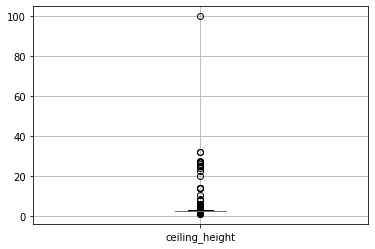

In [30]:
data.boxplot(column='ceiling_height')
plt.show()

Видим, что есть значение высоты равное 100м, которое явно выбивается из всего массива данных. Удалим строку с этим значением.

In [31]:
data = data.loc[data['ceiling_height'] != 100]

Создадим переменную для сортированных по возрастанию значений высот потолков и выведем только уникальные ее значения.

In [32]:
ceiling_height_sorrted=data['ceiling_height'].sort_values()
ceiling_height_sorrted

22590     1.00
5712      1.20
16934     1.75
11352     2.00
16884     2.00
         ...  
21824    27.00
20478    27.00
21377    27.50
3148     32.00
22336    32.00
Name: ceiling_height, Length: 23649, dtype: float64

Видим, что в столбце есть данные с очень низкими значениями, несвойственными для значения высоты потолков в жилом помещении. Будем считать, что высота потолка в квартире не может быть ниже 2,3 м. Удалим все строки со значениями меньше данного числа.

In [33]:
data = data.loc[data['ceiling_height'] >= 2.3]

Также видим, что в столбце есть значения явно превышающие возможные значения высоты потолка в квартире. Будем считать, что высота потолка не может быть выше 4,5 м. Мы могли бы удалить все строки, выше 4,5 м, но видим, что есть значения в районе 20-30м. Это больше похоже на опечатку. Скорее всего, тут неверно поставлена запятая. Тогда предалагаю, для значений в пределах 4,5-23м строки удалить, а для значений больше либо равными 23 перезаписать значения, получив их поделив старое на 10.

In [34]:
data = data.loc[(data['ceiling_height'] <= 4.5) | (data['ceiling_height'] >= 23)]
data.loc[data['ceiling_height'] > 23, 'ceiling_height'] = data['ceiling_height']/10

Построим гистограмму для столбца `ceiling_height`.

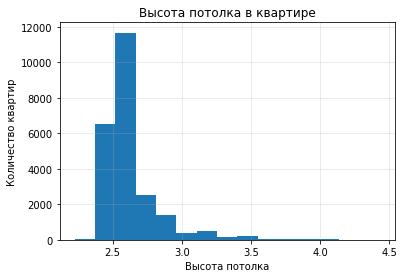

In [35]:
plt.hist(data['ceiling_height'], align='left', bins=15)
plt.title('Высота потолка в квартире')
plt.grid(alpha = 0.3)
plt.xlabel('Высота потолка')
plt.ylabel('Количество квартир')
plt.show()

Распределение вполне характерно для типичной высоты потолков в квартирах.


##### Количество комнат

Построим диаграмму размаха для поиска аномалий.

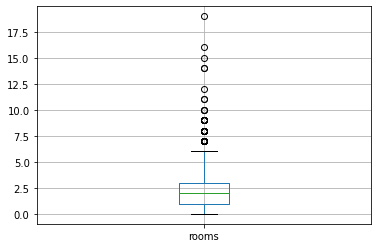

In [36]:
data.boxplot(column='rooms')
plt.show()

Посмотрим количество уникальных значений с помощью метода `value_counts`.

In [37]:
data['rooms'].value_counts()

1     8021
2     7914
3     5789
4     1174
5      322
0      196
6      104
7       58
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

Видим, что квартир с количеством комнат >10 значительно меньше всех остальных. Отсавим в датафрейме только квартиры до 10 комнат.

In [38]:
data = data.loc[data['rooms'] <= 10]

Также в датафрейме есть квартиры, для которых количество комнат указано равное 0. Вероятно это квартиры студии. Посмотрим, чему равна медианная площадь для квартир с разным количеством комнат.

In [39]:
data.groupby('rooms')['total_area'].agg('median')

rooms
0      26.025
1      36.560
2      53.000
3      72.900
4      99.500
5     145.200
6     184.000
7     213.500
8     235.700
9     300.950
10    272.600
Name: total_area, dtype: float64

Как видим, для квартир с "0" в графе количество комнат, меданная площадь составляет 26 кв.м. — это вполне соотвествует площади квартиры-студии.

Также у нас в таблице есть отдельный столбец `studio` для обозначения квартира-студия или нет. Проверим по этому столбцу.

In [40]:
data.groupby('rooms')['studio'].agg('median')

rooms
0      True
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
Name: studio, dtype: bool

Как видим, действительно, квратиры с 0 комнат — это студии.

##### Количество этажей

Построим диаграмму размаха для поиска аномалий.

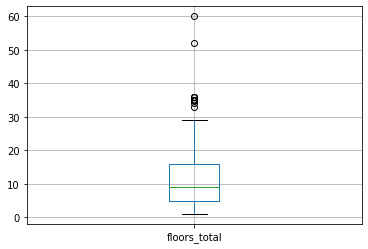

In [41]:
data.boxplot(column='floors_total')
plt.show()

Сразу видим, что есть выбросы. Удалим из датафрейма квартиры в домах с такой этажностью.

In [42]:
data = data.loc[data['floors_total'] < 50]

Теперь посмотрим количество уникальных значений с помощью метода `value_counts`.

In [43]:
data['floors_total'].value_counts()

5     5760
9     3762
16    1372
12    1365
4     1199
10    1177
25    1074
6      917
17     832
3      668
7      590
14     553
18     507
24     464
8      395
2      380
15     367
23     350
19     342
22     287
20     273
13     232
11     205
27     164
21     162
26     123
1       28
35      24
28      21
36       3
34       1
29       1
33       1
Name: floors_total, dtype: int64

Тут отбрасывать самые редкие значения (33, 29, 34) не считаю верным, т.к. есть дома с большей этажностью, которые встречаются чаще (например 35 этажей).

##### Этаж

Построим диаграмму размаха для поиска аномалий.

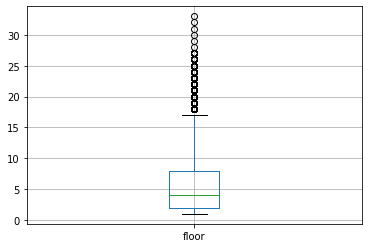

In [44]:
data.boxplot(column='floor')
plt.show()

По диаграмме выбросов не видно.

##### Количество балконов

Построим диаграмму размаха для поиска аномалий.

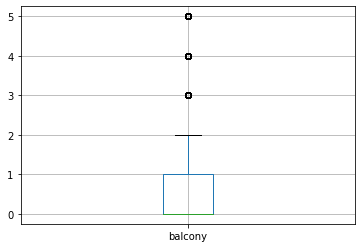

In [45]:
data.boxplot(column='balcony')
plt.show()

Теперь посмотрим количество уникальных значений с помощью метода `value_counts`.

In [46]:
data['balcony'].value_counts()

0    15203
1     4177
2     3654
5      302
4      182
3       81
Name: balcony, dtype: int64

Тут отбрасывать нечего. Данные выглядят нормальными.

##### Жилая площадь

Построим диаграмму размаха для поиска аномалий.

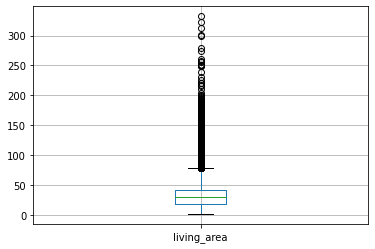

In [47]:
data.boxplot(column='living_area')
plt.show()

Отсортируем значения жилой площади по возрастанию.

In [48]:
data['living_area'].sort_values()

13915      2.0
21758      2.0
3242       3.0
23574      3.0
17582      5.0
         ...  
14088    300.0
8018     301.5
660      312.5
12859    322.3
4237     332.0
Name: living_area, Length: 23599, dtype: float64

Посмотрим нормы для жилых помещений.

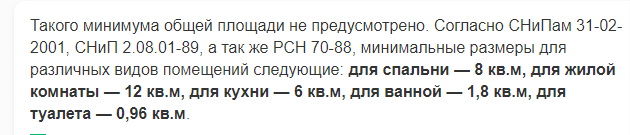

Как видим спальня (что тоже относится к жилым помещениям) не может быть меньше 8 кв.м. Уберем из датафрейма квартиры с жилой площадью меньше 8 кв.м. и больше 200 кв.м.

In [49]:
data = data.loc[(data['living_area'] >= 8) & (data['living_area'] <= 200)]

##### Площадь кухни

Построим диаграмму размаха для поиска аномалий.

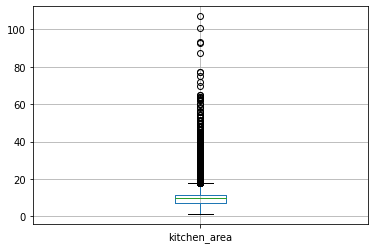

In [50]:
data.boxplot(column='kitchen_area')
plt.show()

Построим диаграмму

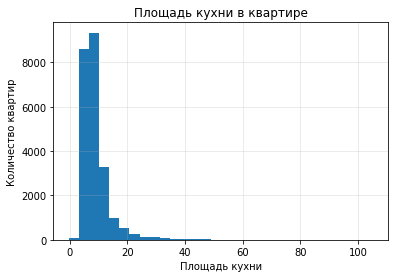

In [51]:
plt.hist(data['kitchen_area'], align='left', bins=30)
plt.title('Площадь кухни в квартире')
plt.grid(alpha = 0.3)
plt.xlabel('Площадь кухни')
plt.ylabel('Количество квартир')
plt.show()

Предлагаю отбросить все квартиры с площадью кухни больше 80 кв.м.

In [52]:
data = data.loc[data['kitchen_area'] < 80]

Отсортируем теперь значения площади кухни по возрастанию.

In [53]:
data['kitchen_area'].sort_values()

20217     1.3
16367     2.0
19642     2.0
6262      2.0
11033     2.0
         ... 
6193     70.0
16647    72.0
14644    75.0
4394     77.0
492      77.0
Name: kitchen_area, Length: 23560, dtype: float64

Выведем теперь медианные значения площади кухни для квартир с разным количеством комнат.

In [54]:
data.groupby('rooms')['kitchen_area'].agg('median')

rooms
0      9.9
1      9.5
2      9.0
3      9.9
4     10.5
5     14.0
6     18.0
7     17.0
8     23.1
9     12.8
10    19.8
Name: kitchen_area, dtype: float64

Как видим в квартирах любой площади, медианные значения площади кухни начинаются от 9 кв.м. и не превышают 23 кв.м. Возможно, кухни площадью сильно меньше 9 кв.м. (1,3 или 2,0 кв.м.) получились ввиду ошибки в постановке запятой. Уберем из датафрейма квартиры с площадью кухонь меньше 6 кв.м. и больше 30 кв.м.

In [55]:
data = data.loc[(data['kitchen_area'] >= 6) & (data['kitchen_area'] <= 30)]

##### Общая площадь

Построим диаграмму размаха для поиска аномалий.

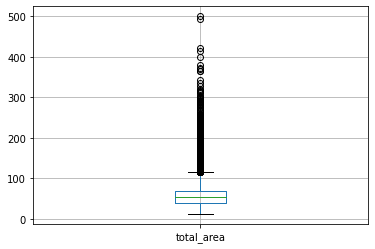

In [56]:
data.boxplot(column='total_area')
plt.show()

Построим гистограмму

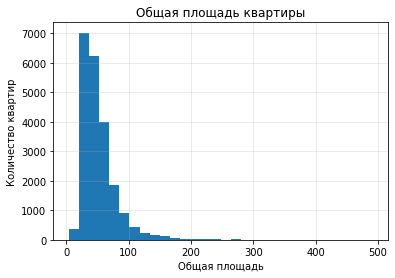

In [57]:
plt.hist(data['total_area'], align='left', bins=30)
plt.title('Общая площадь квартиры')
plt.grid(alpha = 0.3)
plt.xlabel('Общая площадь')
plt.ylabel('Количество квартир')
plt.show()

Предлагаю отбросить все квартиры общей площадью больше 250 кв.м.

In [58]:
data = data.loc[data['total_area'] <= 250]

Отсортируем теперь значения общей площади по возрастанию.

In [59]:
data['total_area'].sort_values()

19904     12.0
19546     13.0
17961     13.0
19807     13.0
19558     13.2
         ...  
21023    248.7
681      249.0
13019    249.9
13931    250.0
20791    250.0
Name: total_area, Length: 21494, dtype: float64

Выведем теперь медианные значения общей площади для квартир с разным количеством комнат.

In [60]:
data.groupby('rooms')['total_area'].agg('median')

rooms
0      26.05
1      37.00
2      54.00
3      73.80
4     100.00
5     136.00
6     166.75
7     189.90
8     232.00
9     249.90
10    216.10
Name: total_area, dtype: float64

Значения выглядят нормальными.

##### Цена на момент снятия объявления

Построим диаграмму размаха для поиска аномалий.

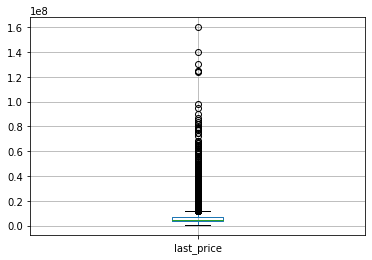

In [61]:
data.boxplot(column='last_price')
plt.show()

Построим гистограмму

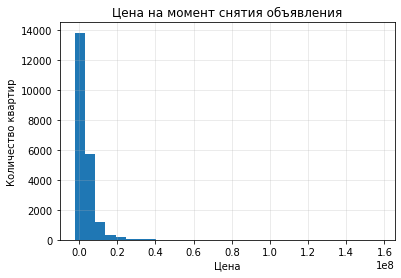

In [62]:
plt.hist(data['last_price'], align='left', bins=30)
plt.title('Цена на момент снятия объявления')
plt.grid(alpha = 0.3)
plt.xlabel('Цена')
plt.ylabel('Количество квартир')
plt.show()

Видим явный выброс и очевидно редкие значения. Уберем из датафрейма квартиры дороже 100 млн. рублей.

In [63]:
data = data.loc[data['last_price'] <= 100000000]

### Добавление в таблицу новых столбцов

#### Цена одного квадратного метра

Создадим новый столбец `cost_per_m` и посчитаем его значения.

In [64]:
data['cost_per_m'] = (data['last_price']/data['total_area']).astype('int')

#### День недели публикации объявления

Создадим новый столбец `week_day_exposition_type` с типом дня недели публикации объявления.

In [65]:
data['week_day_exposition_type']=data['first_day_exposition'].dt.weekday

Создадим новый столбец с `week_day_exposition` с названием дня недели.

In [66]:
def week_day (week_day_type):
    if week_day_type ['week_day_exposition_type'] == 0:
        return 'понедельник'
    elif week_day_type ['week_day_exposition_type'] == 1:
        return 'вторник'
    elif week_day_type ['week_day_exposition_type'] == 2:
        return 'среда'
    elif week_day_type ['week_day_exposition_type'] == 3:
        return 'четверг'
    elif week_day_type ['week_day_exposition_type'] == 4:
        return 'пятница'
    elif week_day_type ['week_day_exposition_type'] == 5:
        return 'суббота'
    else:
        return 'воскресенье'
data['week_day_exposition'] = data.apply(week_day, axis=1)        

#### Месяц публикации объявления

Создадим новый столбец `month_exposition` с месяцем публикации объявлений.

In [67]:
data['month_exposition']=data['first_day_exposition'].dt.month

#### Год публикации объявления

Создадим новый столбец `year_exposition` с годом публикации объявлений.

In [68]:
data['year_exposition']=data['first_day_exposition'].dt.year

#### Тип этажа квартиры

Создадим новый столбец `type_of_floor` с типом этажа квартиры с помощью функции.

In [69]:
def type_of_floor(floor_number):
    if floor_number ['floor'] == 1:
        return 'первый'
    elif floor_number ['floor'] == floor_number['floors_total'] !=1:
        return 'последний'
    else:
        return 'другой'
data['type_of_floor'] = data.apply(type_of_floor, axis=1)        

#### Расстояние до центра города в километрах

Создадим новый столбец `cityCenters_nearest_km` с расстоянием до центра города в километрах.

In [70]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round(0)

#### Проверка

Проверим, все ли столбцы добавились как надо. Выведем первые 5 строк датаффрейма.

In [71]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_m,week_day_exposition_type,week_day_exposition,month_exposition,year_exposition,type_of_floor,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370,3,четверг,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.6,1,False,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920,1,вторник,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785,3,четверг,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.70,14,45.0,9,False,False,False,9.9,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176,4,пятница,7,2015,другой,7.0
5,10,2890000.0,30.4,2018-09-10,1,2.60,12,14.4,5,False,False,False,9.1,0,поселок городского типа Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,95065,0,понедельник,9,2018,другой,NaN


Все в порядке.

### Проведите исследовательский анализ данных

#### Исследование отдельных параметров объектов

##### Общая площадь

Построим гистрограмму.

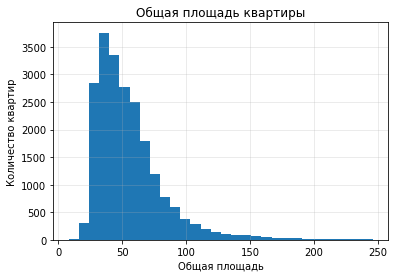

In [72]:
plt.hist(data['total_area'], align='left', bins=30)
plt.title('Общая площадь квартиры')
plt.grid(alpha = 0.3)
plt.xlabel('Общая площадь')
plt.ylabel('Количество квартир')
plt.show()

По гистограмме видно, что большая часть квартир имеет общую площадь в пределах 30-70 кв.м. Распределение выглядит нормальным.

##### Жилая площадь

Построим гистрограмму.

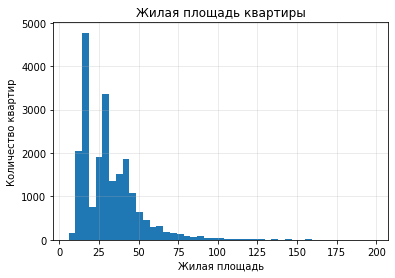

In [73]:
plt.hist(data['living_area'], align='left', bins=45)
plt.title('Жилая площадь квартиры')
plt.grid(alpha = 0.3)
plt.xlabel('Жилая площадь')
plt.ylabel('Количество квартир')
plt.show()

По гистограмме видно, что большая часть квартир имеет жилую площадь в пределах 12-48 кв.м. Скачки в графике обсуловленны стандартов в строительстве и большого количество в продаже типовых квартир. Распределение выглядит нормальным.

##### Площадь кухни

Построим гистрограмму.

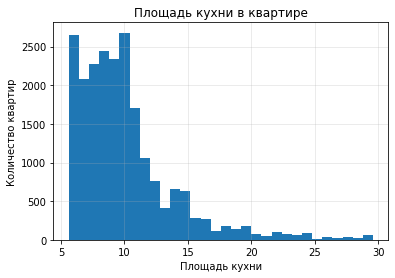

In [74]:
plt.hist(data['kitchen_area'], align='left', bins=30)
plt.title('Площадь кухни в квартире')
plt.grid(alpha = 0.3)
plt.xlabel('Площадь кухни')
plt.ylabel('Количество квартир')
plt.show()

По гистограмме видно, что большая часть квартир имеет площадь кухни в пределах 6-15 кв.м. Распределение выглядит нормальным.

##### Цена объекта

Построим гистрограмму.

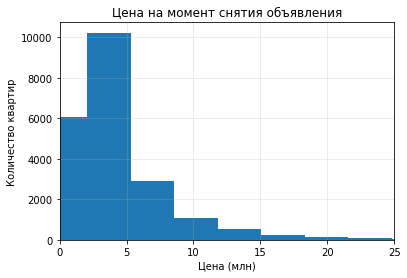

In [75]:
plt.hist(data['last_price']/1000000, align='left', bins=30)
plt.title('Цена на момент снятия объявления')
plt.grid(alpha = 0.3)
plt.xlabel('Цена (млн)')
plt.ylabel('Количество квартир')
plt.xlim(0,25)
plt.show()

По гистограмме видно, что большая часть квартир имеет стоимость в пределах 8 млн. руб. Распределение выглядит нормальным.

##### Количество комнат

Построим гистрограмму.

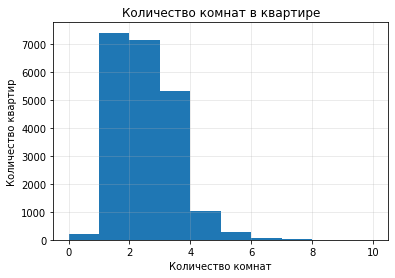

In [76]:
plt.hist(data['rooms'], bins= data['rooms'].max())
plt.title('Количество комнат в квартире')
plt.grid(alpha = 0.3)
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()

По гистограмме видно, что большая часть квартир имеет от 1 до 4 комнат. Распределение выглядит нормальным.

##### Высота потолков

Построим гистрограмму.

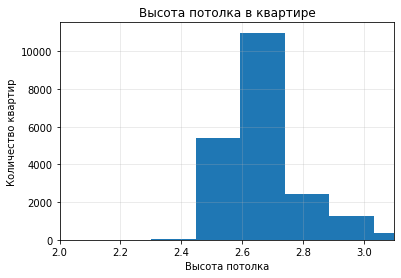

In [77]:
plt.hist(data['ceiling_height'], bins=15)
plt.title('Высота потолка в квартире')
plt.grid(alpha = 0.3)
plt.xlabel('Высота потолка')
plt.ylabel('Количество квартир')
plt.xlim(2,3.1)
plt.show()

По гистограмме видно, что большая часть квартир имеет высоту потолков в пределах 2,5 - 2,7 м. Распределение выглядит нормальным.

##### Этаж квартиры

Построим гистрограмму.

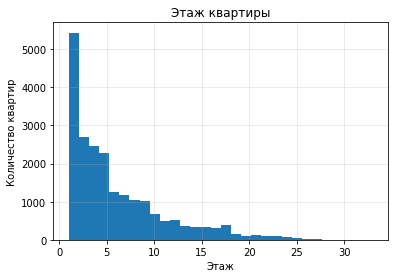

In [78]:
plt.hist(data['floor'],  bins=30)
plt.title('Этаж квартиры')
plt.grid(alpha = 0.3)
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')
plt.show()

По гистограмме видно, что большая часть квартир расположена на 1-5 этажах. Распределение выглядит нормальным.

##### Тип этажа квартиры

Построим гистрограмму.

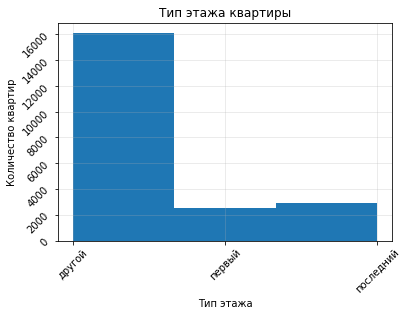

In [79]:
plt.hist(data['type_of_floor'],  bins=3)
plt.title('Тип этажа квартиры')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.grid(alpha = 0.3)
plt.xlabel('Тип этажа')
plt.ylabel('Количество квартир')
plt.show()

По гистограмме видно, что большая часть квартир расположена не на первом и не на последнем этажах. Распределение выглядит нормальным.

##### Общее количество этажей в доме

Построим гистрограмму.

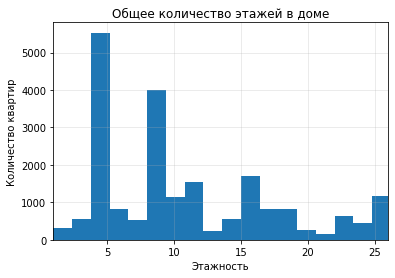

In [80]:
plt.hist(data['floors_total'], bins=25)
plt.title('Общее количество этажей в доме')
plt.grid(alpha = 0.3)
plt.xlabel('Этажность')
plt.ylabel('Количество квартир')
plt.xlim(1,26)
plt.show()

По гистограмме видно, что большая часть домов в таблице имеет этажность 4, 5, 9, 11, 16 и 26 этажей. Это следствие распространения типовых застроек.

##### Расстояние до центра города в метрах

Построим гистрограмму.

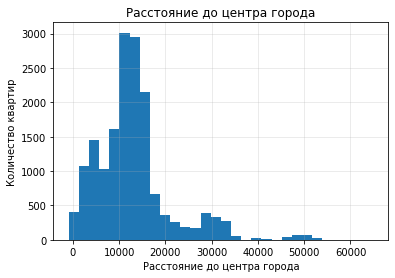

In [81]:
plt.hist(data['cityCenters_nearest'], align='left', bins=30)
plt.title('Расстояние до центра города')
plt.grid(alpha = 0.3)
plt.xlabel('Расстояние до центра города')
plt.ylabel('Количество квартир')
plt.show()

На гистограмме видим несколько "всплесков" вокруг которых сконцентрированны данные: 10000, 30000, 50000. Предположу, что это связано с тем, что в датафрейме собраны квартиры из разных населенных пунктов.

##### Расстояние до ближайшего аэропорта

Построим гистрограмму.

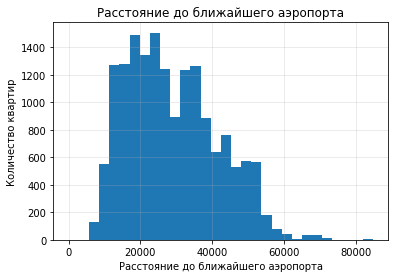

In [82]:
plt.hist(data['airports_nearest'],  bins=30)
plt.title('Расстояние до ближайшего аэропорта')
plt.grid(alpha = 0.3)
plt.xlabel('Расстояние до ближайшего аэропорта')
plt.ylabel('Количество квартир')
plt.show()

По гистограмме видно, что большая часть квартир расположена на удалении 40000 м до аэропорта. Это обусловлено расположением самого аэропорта.

##### Расстояние до ближайшего парка

Построим гистрограмму.

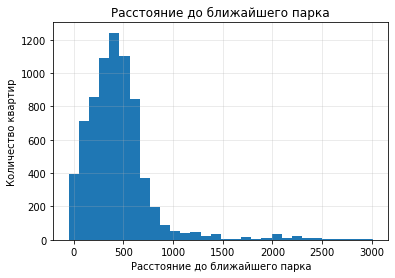

In [83]:
plt.hist(data['parks_nearest'], align='left', bins=30)
plt.title('Расстояние до ближайшего парка')
plt.grid(alpha = 0.3)
plt.xlabel('Расстояние до ближайшего парка')
plt.ylabel('Количество квартир')
plt.show()

По гистограмме видно, что большая часть квартир расположена в пределах 600 м до ближайшего парка. Это говорит о том, что парки распространены и это хорошо)

##### День и месяц публикации объявления

##### День недели публикации объявления

Построим гистрограмму распределения количества объявлений по дням недели.

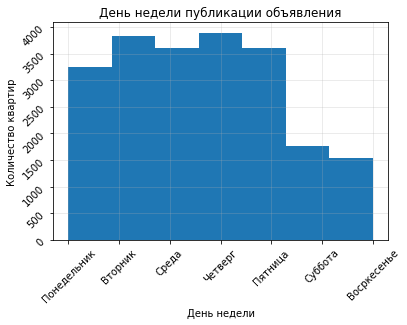

In [84]:
plt.hist(data['week_day_exposition_type'], bins=7)
plt.title('День недели публикации объявления')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Восркесенье'] ,rotation=45)
plt.yticks(rotation=45)
plt.grid(alpha = 0.3)
plt.xlabel('День недели')
plt.ylabel('Количество квартир')
plt.show()

Из гистограммы видно, что объявления о продаже часто вешают в будни, что логично - чем еще заняться на работе, как не повесить объявление о продаже квартиры. Выходные, чтобы отдыхать! 

##### Месяц публикации объявления

Построим гистограмму для распределения объявлений по месяцам.

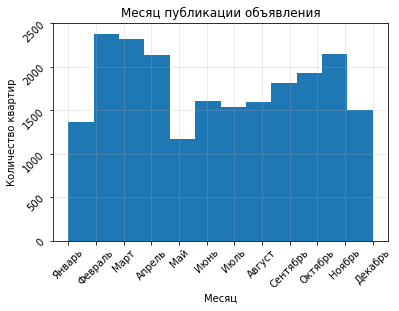

In [85]:
plt.hist(data['month_exposition'], bins=12, range=(1,12))
plt.title('Месяц публикации объявления')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'], rotation=45)
plt.yticks(rotation=45)
plt.grid(alpha = 0.3)
plt.xlabel('Месяц')
plt.ylabel('Количество квартир')
plt.show()

По гистограмме видим, что самыми непопулярными месяцами для публикации объявлений о продаже квратир являются декабрь, январь и май (особенно!). Тут все логично, люди заняты праздничными заботами. И наоброт самыми популярными являются февраль, март, апрель и ноябрь.

#### Изучение скорости продажи квартир

Построим гистрограмму.

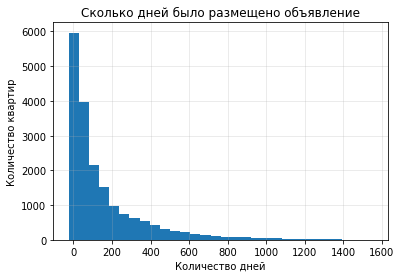

In [86]:
plt.hist(data['days_exposition'], align='left', bins=30)
plt.title('Сколько дней было размещено объявление')
plt.grid(alpha = 0.3)
plt.xlabel('Количество дней')
plt.ylabel('Количество квартир')
plt.show()

Посмотрим, чему равно среднее количество дней, необходимое для продажи.

In [87]:
data['days_exposition'].mean().astype('int')

179

Посмотрим, чему равно медианное количество дней, необходимое для продажи.

In [88]:
data['days_exposition'].median().astype('int')

95

Обычно продажа квартиры занимет 3 месяца. Быстрыми можно считать продажи в течение 1,5 месяцев, а необычно долгими, продажи продолжительностью дольше 1,5 года.

#### Анализ зависимости стоимости жилья от различных фаторов

##### От общей площади

Построим точечную диаграмму зависимости стоимости объекта от его общей площади.

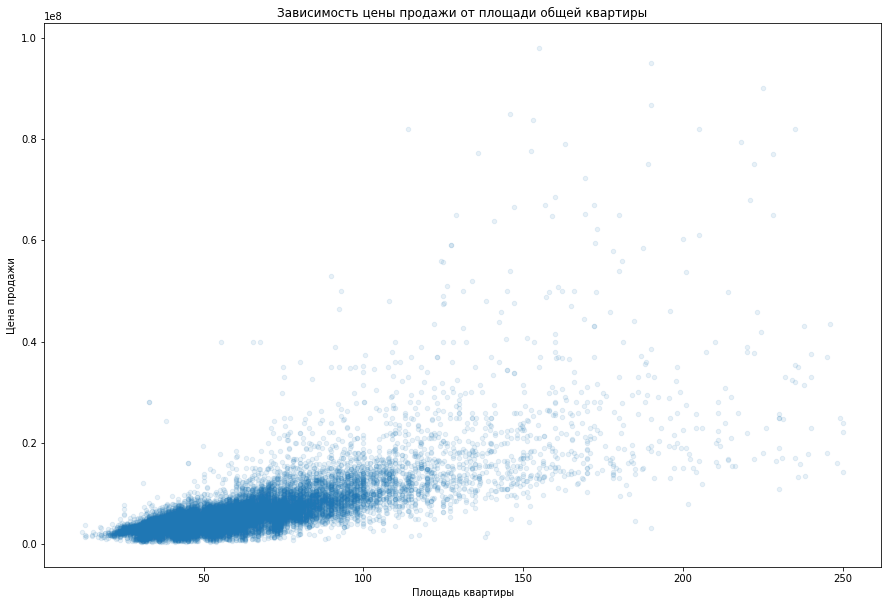

In [89]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.1, figsize=(15, 10)) 
plt.title('Зависимость цены продажи от площади общей квартиры')
plt.xlabel('Площадь квартиры')
plt.ylabel('Цена продажи')
plt.show()

Из графика видно, что с увеличением общей площади растет и стоимость квартиры.

Проверим с помощью расчета коррекляции.

In [90]:
data['total_area'].corr(data['last_price'])

0.7310922107911018

Как видим коэффициент корреляции больше нуля и стремится к единице, значит наши выводы о зависимости верные.

##### От жилой площади

Построим точечную диаграмму зависимости стоимости объекта от его общей площади.

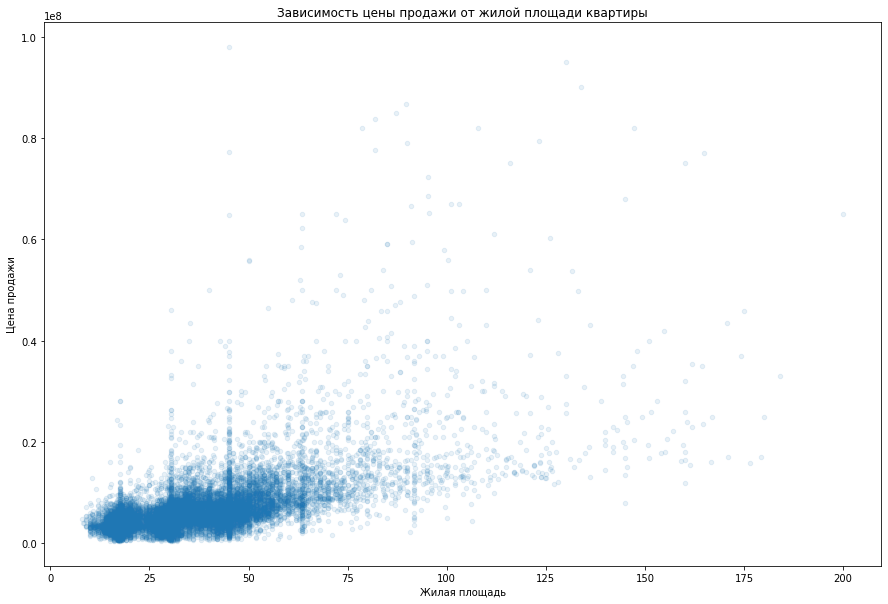

In [91]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.1, figsize=(15, 10)) 
plt.title('Зависимость цены продажи от жилой площади квартиры')
plt.xlabel('Жилая площадь')
plt.ylabel('Цена продажи')
plt.show()

Из графика видно, что с увеличением жилой площади растет и стоимость квартиры.

Проверим с помощью расчета коррекляции.

In [92]:
data['living_area'].corr(data['last_price'])

0.6290533975154967

Как видим коэффициент корреляции больше нуля и стремится к единице, значит наши выводы о зависимости верные.

##### От площади кухни

Создадим функцию для группировки значений площадей кухни по группам. С помощью функции создадим новый столбец `kitchen_area_group` в основном датафрейме.

In [93]:
def kitchen_area_group(kitchen_area):
    if kitchen_area <= 6:
        return '3-6 кв.м.'
    if 6 < kitchen_area <= 9:
        return '6,1-9 кв.м.'
    if 9 < kitchen_area <= 12:
        return '9,1-12 кв.м.'
    if 12 < kitchen_area <= 15:
        return '12,1-15 кв.м.'
    if 15 < kitchen_area <= 18:
        return '15,1-18 кв.м.'
    if 18 < kitchen_area <= 21:
        return '18,1-21 кв.м.'
    if 21 < kitchen_area <= 24:
        return '21,1-24 кв.м.'
    if 24 < kitchen_area <= 27:
        return '24,1-27 кв.м.'
    return '27,1-30 кв.м.'
data['kitchen_area_group']=data['kitchen_area'].apply(kitchen_area_group) 

Создадим сводную таблицу с новым столбцом `kitchen_area_group` и медианными занчениями цены продажи для квартир из этих групп.

In [94]:
data_kitchen_pivot = pd.pivot_table(data, index=['kitchen_area_group'], values=['last_price'], aggfunc='median').reset_index()

In [95]:
data_kitchen_pivot

,kitchen_area_group,last_price
0,"12,1-15 кв.м.",6900000.0
1,"15,1-18 кв.м.",9170000.0
2,"18,1-21 кв.м.",10200000.0
3,"21,1-24 кв.м.",11675000.0
4,"24,1-27 кв.м.",11500000.0
5,"27,1-30 кв.м.",12690000.0
6,3-6 кв.м.,3295000.0
7,"6,1-9 кв.м.",4050000.0
8,"9,1-12 кв.м.",4950000.0


Построим столбчатую диаграмму для сводной таблицы.

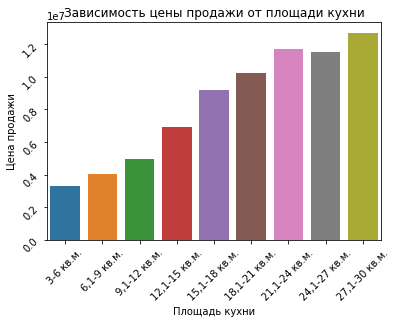

In [96]:
import seaborn as sns
sns.barplot(
    data=data_kitchen_pivot, 
    x='kitchen_area_group', 
    y='last_price',
    order=['3-6 кв.м.', '6,1-9 кв.м.', '9,1-12 кв.м.', '12,1-15 кв.м.', '15,1-18 кв.м.', '18,1-21 кв.м.', '21,1-24 кв.м.', '24,1-27 кв.м.', '27,1-30 кв.м.'])
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Зависимость цены продажи от площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Цена продажи')
plt.show()

Как видим, площадь кухни напрямую влияет на цену продажи квартиры (с возрастанием площади кухни, растет и цена).

Проверим с помощью расчета коррекляции.

In [97]:
data['kitchen_area'].corr(data['last_price'])

0.47712063854332687

Коэффициент корреляции больше нуля и стремится к единице, значит наши выводы о зависимости верные.

##### От количества комнат

Создадим функцию для группировки квартир по количеству комнат. С помощью функции создадим новый столбец `rooms_group` в основном датафрейме.

In [98]:
def rooms_group(rooms):
    if rooms < 1:
        return 'Студия'
    if 1 <= rooms < 2:
        return '1-комнатная'
    if 2 <= rooms < 3:
        return '2-комнатная'
    if 3 <= rooms < 4:
        return '3-комнатная'
    if 4 <= rooms < 5:
        return '4-комнатная'
    if 5 <= rooms < 6:
        return '5-комнатная'
    if 6 <= rooms < 7:
        return '6-комнатная'
    if 7 <= rooms < 8:
        return '7-комнатная'
    if 8 <= rooms < 9:
        return '8-комнатная'
    if 9 <= rooms < 10:
        return '9-комнатная'
    return '10-комнатная'
data['rooms_group']=data['rooms'].apply(rooms_group) 

Создадим сводную таблицу с новым столбцом `rooms_group` и медианными занчениями цены продажи для квартир из этих групп.

In [99]:
data_rooms_pivot = pd.pivot_table(data, index=['rooms_group'], values=['last_price'], aggfunc='median').reset_index()

In [100]:
data_rooms_pivot

,rooms_group,last_price
0,1-комнатная,3670000.0
1,10-комнатная,15500000.0
2,2-комнатная,4950000.0
3,3-комнатная,6300000.0
4,4-комнатная,9100000.0
5,5-комнатная,12790000.0
6,6-комнатная,16500000.0
7,7-комнатная,17650000.0
8,8-комнатная,17250000.0
9,9-комнатная,22250000.0


Построим столбчатую диаграмму для сводной таблицы.

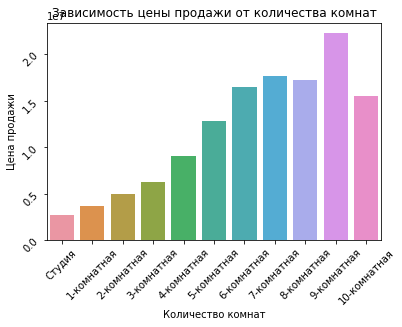

In [101]:
sns.barplot(
    data=data_rooms_pivot, 
    x='rooms_group', 
    y='last_price',
    order=['Студия', '1-комнатная', '2-комнатная', '3-комнатная', '4-комнатная', '5-комнатная', '6-комнатная', '7-комнатная', '8-комнатная', '9-комнатная', '10-комнатная'])
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Зависимость цены продажи от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена продажи')
plt.show()

Как видим количество комнат прямо влияет на цену продажи квартиры — чем больше комнат, тем выше цена. Но после 9ти комнат зависимость уже не наблюдается.

Проверим с помощью расчета коррекляции.

In [102]:
data['rooms'].corr(data['last_price'])

0.464848893026462

Коэффициент корреляции больше нуля и стремится к единице, значит наши выводы о зависимости верные.

##### От этажа, на котором расположена квартира (первый, последний, другой)

Создадим сводную таблицу

In [103]:
data_type_of_floor_pivot = pd.pivot_table(data, index=['type_of_floor'], values=['last_price'], aggfunc='median').reset_index()

In [104]:
data_type_of_floor_pivot

,type_of_floor,last_price
0,другой,4900000.0
1,первый,4050000.0
2,последний,4500000.0


Построим столбчатую диаграмму для сводной таблицы.

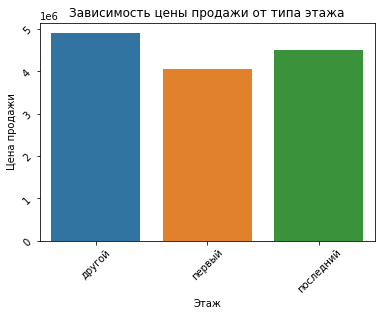

In [105]:
sns.barplot(
    data=data_type_of_floor_pivot, 
    x='type_of_floor', 
    y='last_price')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Зависимость цены продажи от типа этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена продажи')
plt.show()

Из диаграммы видно, цена выше для квартир на средних этажах и ниже для квартир на первом этаже.

##### От даты размещения (день недели, месяц, год)

###### День недели

Создадим сводную таблицу

In [106]:
data_week_day_exposition_pivot = pd.pivot_table(data, index=['week_day_exposition'], values=['last_price'], aggfunc='median').reset_index()

In [107]:
data_week_day_exposition_pivot

,week_day_exposition,last_price
0,воскресенье,4631000.0
1,вторник,4840000.0
2,понедельник,4775500.0
3,пятница,4700000.0
4,среда,4848500.0
5,суббота,4650259.0
6,четверг,4799500.0


Построим столбчатую диаграмму для сводной таблицы.

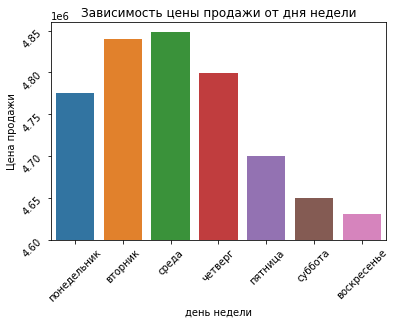

In [108]:
sns.barplot(
    data=data_week_day_exposition_pivot, 
    x='week_day_exposition', 
    y='last_price',
    order=['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье'])
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Зависимость цены продажи от дня недели')
plt.xlabel('день недели')
plt.ylabel('Цена продажи')
plt.ylim(4600000, 4860000)
plt.show()

Видим, что пик цены приходится на середину недели и плавно спадает к выходным. Видимо на выходных терпение у людей заканчивается и они снижают цену.

###### Месяц

Создадим сводную таблицу

In [109]:
data_month_exposition_pivot = pd.pivot_table(data, index=['month_exposition'], values=['last_price'], aggfunc='median').reset_index()

In [110]:
data_month_exposition_pivot

,month_exposition,last_price
0,1,4700000.0
1,2,4800000.0
2,3,4800000.0
3,4,4919500.0
4,5,4650000.0
5,6,4540000.0
6,7,4700000.0
7,8,4750000.0
8,9,4800000.0
9,10,4690000.0


Построим столбчатую диаграмму для сводной таблицы.

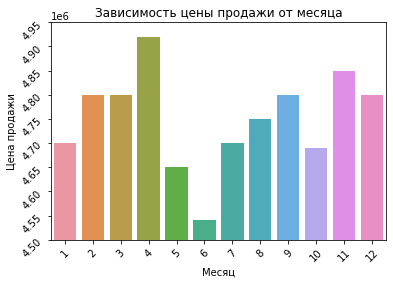

In [111]:
sns.barplot(
    data=data_month_exposition_pivot, 
    x='month_exposition', 
    y='last_price')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Зависимость цены продажи от месяца')
plt.xlabel('Месяц')
plt.ylabel('Цена продажи')
plt.ylim(4500000, 4950000)
plt.show()

Видим, что пик цен приходится на апрель, а минимум на июнь, что объясняется началом отпускного сезона и спада покупательской активности.

###### Год

Создадим сводную таблицу

In [112]:
data_year_exposition_pivot = pd.pivot_table(data, index=['year_exposition'], values=['last_price'], aggfunc='median').reset_index()

In [113]:
data_year_exposition_pivot

,year_exposition,last_price
0,2014,7388280.0
1,2015,5390000.0
2,2016,4700000.0
3,2017,4600000.0
4,2018,4680000.0
5,2019,5200000.0


Построим столбчатую диаграмму для сводной таблицы.

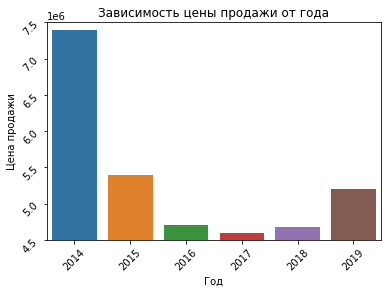

In [114]:
sns.barplot(
    data=data_year_exposition_pivot, 
    x='year_exposition', 
    y='last_price')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Зависимость цены продажи от года')
plt.xlabel('Год')
plt.ylabel('Цена продажи')
plt.ylim(4500000, 7500000)
plt.show()

Видим, что пик цен выпал на 2014, возможно это связано с кризисом.

#### Анализ стоимости квадратного метра жилья в 10 населенных пунктах с наибольшим числом объявлений

Создадим новый датафрейм, куда добавим сгруппироавнные данные по количеству объявлений в каждом населенном пункте. Отсортируем данные по убыванию и выведем первые 10 строк.

In [115]:
data_locality_name = data.groupby('locality_name')['floor'].count()
data_locality_name = data_locality_name.sort_values(ascending=False)
data_locality_name.head(10)

locality_name
Санкт-Петербург      14526
Мурино                 579
Кудрово                465
поселок Шушары         422
Всеволожск             380
поселок Парголово      322
Колпино                308
Пушкин                 282
Гатчина                226
Выборг                 203
Name: floor, dtype: int64

Теперь мы знаем населенные пункты с самым большим числом объявлений.

Создадим новую таблицу, в которую войдут только данные с этими населенными пунктами.

In [116]:
data_locality_name_price = data.loc[(data['locality_name'] == 'Санкт-Петербург') | 
                               (data['locality_name'] == 'Мурино') |
                               (data['locality_name'] == 'Кудрово') | 
                               (data['locality_name'] == 'поселок Шушары') |
                               (data['locality_name'] == 'Всеволожск') | 
                               (data['locality_name'] == 'поселок Парголово') |
                               (data['locality_name'] == 'Колпино') | 
                               (data['locality_name'] == 'Гатчина') |
                               (data['locality_name'] == 'Выборг')]

In [117]:
data_locality_name_price

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_m,week_day_exposition_type,week_day_exposition,month_exposition,year_exposition,type_of_floor,cityCenters_nearest_km,kitchen_area_group,rooms_group
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370,3,четверг,3,2019,другой,16.0,"24,1-27 кв.м.",3-комнатная
1,7,3350000.0,40.40,2018-12-04,1,2.63,11,18.6,1,False,False,False,11.00,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920,1,вторник,12,2018,первый,19.0,"9,1-12 кв.м.",1-комнатная
2,10,5196000.0,56.00,2015-08-20,2,2.70,5,34.3,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785,3,четверг,8,2015,другой,14.0,"6,1-9 кв.м.",2-комнатная
3,0,64900000.0,159.00,2015-07-24,3,2.70,14,45.0,9,False,False,False,9.90,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176,4,пятница,7,2015,другой,7.0,"9,1-12 кв.м.",3-комнатная
6,6,3700000.0,37.30,2017-11-02,1,2.64,26,10.6,6,False,False,False,14.40,1,поселок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0,99195,3,четверг,11,2017,другой,19.0,"12,1-15 кв.м.",1-комнатная
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,13,3550000.0,35.30,2018-02-28,1,2.86,15,16.3,4,False,False,False,9.10,2,Санкт-Петербург,17284.0,16081.0,1,353.0,2,652.0,29.0,100566,2,среда,2,2018,другой,16.0,"9,1-12 кв.м.",1-комнатная
23690,3,5500000.0,52.00,2018-07-19,2,2.70,5,31.0,2,False,False,False,6.00,0,Санкт-Петербург,20151.0,6263.0,1,300.0,0,NaN,15.0,105769,3,четверг,7,2018,другой,6.0,3-6 кв.м.,2-комнатная
23691,11,9470000.0,72.90,2016-10-13,2,2.75,25,40.3,7,False,False,False,10.60,1,Санкт-Петербург,19424.0,4489.0,0,NaN,1,806.0,519.0,129903,3,четверг,10,2016,другой,4.0,"9,1-12 кв.м.",2-комнатная
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.3,3,False,False,False,13.83,0,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,NaN,72490,1,вторник,3,2017,другой,4.0,"12,1-15 кв.м.",3-комнатная


Создадим сводную таблицу для подсчета медианных значений стоимости квадратного метра для данных населенных пунктов.

In [118]:
data_locality_name_price_pivot = pd.pivot_table(data_locality_name_price, index=['locality_name'], values=['cost_per_m'], aggfunc='median').reset_index()

Отсортируем полученную таблицу по возрастанию занчения стоимости 1 квадратного метра.

In [119]:
data_locality_name_price_pivot.sort_values(by='cost_per_m')

,locality_name,cost_per_m
1,Выборг,58666.0
0,Всеволожск,65934.0
2,Гатчина,69462.0
3,Колпино,75000.0
8,поселок Шушары,77222.5
5,Мурино,86075.0
7,поселок Парголово,91779.5
4,Кудрово,95588.0
6,Санкт-Петербург,104938.5


Построим столбчатую диазрамму.

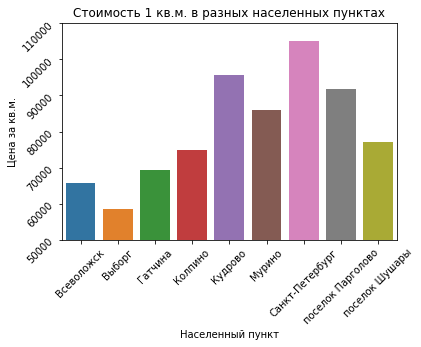

In [120]:
sns.barplot(
    data=data_locality_name_price_pivot, 
    x='locality_name', 
    y='cost_per_m')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Стоимость 1 кв.м. в разных населенных пунктах')
plt.xlabel('Населенный пункт')
plt.ylabel('Цена за кв.м.')
plt.ylim(50000,110000)
plt.show()

Как видим самая низкая цена квадратного метра в Выборге, а самая высокая в Санкт-Петербурге.

#### Анализ зависимости стоимости объектов от расстояния до центра города

Создадим новую таблицу, в которую войдут только квартиры из Санкт-Петербурга.

In [121]:
data_locality_price = data.loc[(data['locality_name'] == 'Санкт-Петербург')]

Создадим сводную тыблицу для расчета медианного значения стоимости квдаратного метра жилья в зависимости от удаления квартиры от центра.

In [122]:
data_locality_price_pivot = pd.pivot_table(data_locality_price, index=['cityCenters_nearest_km'], values=['cost_per_m'], aggfunc='median').reset_index()

In [123]:
data_locality_price_pivot

,cityCenters_nearest_km,cost_per_m
0,0.0,139318.0
1,1.0,126617.5
2,2.0,117958.0
3,3.0,108139.0
4,4.0,116857.0
5,5.0,125797.5
6,6.0,131428.0
7,7.0,124615.0
8,8.0,122944.0
9,9.0,107457.0


Построим столбчатую диаграмму для сводной таблицы.

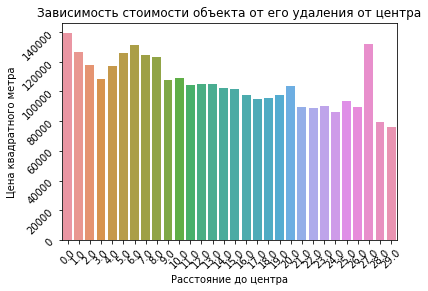

In [124]:
sns.barplot(
    data=data_locality_price_pivot, 
    x='cityCenters_nearest_km', 
    y='cost_per_m')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Зависимость стоимости объекта от его удаления от центра')
plt.xlabel('Расстояние до центра')
plt.ylabel('Цена квадратного метра')
plt.show()

Как видим, с удалением от центра города на каждый километр цена снижается. Предположу, что центр заканчивается на 8 км.

### Общий вывод

Из полученных данных можем сделать следующие выводы:
* среднестатистическая квартира в объявлении:
 * имеет:
   * общую площадь в пределах 30-70 кв.м.;
   * жилую площадь в пределах 12-48 кв.м.;
   * площадь кухни в пределах 6-15 кв.м.;
   * стоимость в пределах 8 млн. руб.;
   * от 1 до 4 комнат;
   * высоту потолков в пределах 2,5 - 2,7 м;
 * расположена:
   * на 1-5 этажах;
   * чаще не на первом и не на последнем этажах;
   * в доме этажностью 4, 5, 9, 11, 16 или 26 этажей;
   * на удалении 40000 м до аэропорта;
   * в пределах 600 м до ближайшего парка;
* объявления о продаже часто вешают:
 * в будни;
 * в феврале, марте, апреле или ноябре, реже в декабре, январе и мае;
* обычно продажа квартиры занимет 3 месяца;
* для стоимости квартиры характерны следующие зависимости:
 * с увеличением общей площади растет и стоимость квартиры;
 * с увеличением жилой площади растет и стоимость квартиры;
 * площадь кухни напрямую влияет на цену продажи квартиры (с возрастанием площади кухни, растет и цена);
 * чем больше комнат, тем выше цена. Но после 9ти комнат зависимость уже не наблюдается;
 * цена выше для квартир на средних этажах и ниже для квартир на первом этаже;
 * пик цены приходится на середину недели и плавно спадает к выходным;
 * пик цен приходится на апрель, а минимум на июнь;
 * пик цен выпал на 2014 (ощутимо влияние общеэкономической обстановки в стране);
 * самая низкая цена квадратного метра в Выборге, а самая высокая в Санкт-Петербурге;
 * с удалением от центра города на каждый километр цена снижается.